# Group Project

### Libraries required

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import preprocessing
import sklearn
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
sns.set_style("darkgrid")
import plotly.figure_factory as ff
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

## Start of Pre-Processing

In [53]:
train_data = pd.read_csv("train.csv", low_memory = False)
store_data = pd.read_csv("store.csv", low_memory = False)
test_data = pd.read_csv("test.csv", low_memory = False)

In [54]:
def Percentage(df,colname,val):
    return round(df[df[colname]==val].shape[0]/df.shape[0] * 100,2)

def replaceWithZeros(df,col_name):
    df[col_name].fillna(0,inplace =True)
    return df

def findOutliers(df,col_name):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    high_cutoff = Q3 + 1.5*IQR
    low_cutoff = Q1 - 1.5*IQR
    return high_cutoff, low_cutoff

def LevelEncoding(df,col_name):
    labelEncoder = preprocessing.LabelEncoder()
    df[col_name] = labelEncoder.fit_transform(df[col_name])
    return df

### Pre-processing of training data

In [55]:
print("Shape of Training Data",train_data.shape)
print('-----------------------------------')
print('Null Values thorughout the columns:')
train_data.isnull().sum()

Shape of Training Data (1017209, 9)
-----------------------------------
Null Values thorughout the columns:


Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [56]:
pOpen = Percentage(train_data,'Open',1)
print('Percentage of Open Stores in data:',str(pOpen) + ' %')
pClose = Percentage(train_data,'Open',0)
print('Percentage of Closed Stores in data:',str(pClose) + ' %')

Percentage of Open Stores in data: 83.01 %
Percentage of Closed Stores in data: 16.99 %


#### Remove samples in which store is closed and sales are zero

In [57]:
print('Shape of Training before:',train_data.shape)
train_data = train_data[(train_data["Open"] != 0) & (train_data['Sales'] != 0)]
print('-----------------------------------------')
print('Shape of Training after:',train_data.shape)

Shape of Training before: (1017209, 9)
-----------------------------------------
Shape of Training after: (844338, 9)


In [58]:
# QUESTION IN LINE 16 OF UNTITLED60 
# train_data = train_data.drop('Open', axis=1)

#### Split dateTime to year, month and day

In [59]:
train_data['Year'] = pd.DatetimeIndex(train_data['Date']).year
train_data['Month'] = pd.DatetimeIndex(train_data['Date']).month
train_data['Day'] = pd.DatetimeIndex(train_data['Date']).day

#### Adding seasonality to dataBase

In [60]:
train_data['Season'] = np.where(train_data['Month'].isin([3,4,5]), "Spring",
                 np.where(train_data['Month'].isin([6,7,8]), "Summer",
                 np.where(train_data['Month'].isin([9,10,11]), "Fall",
                 np.where(train_data['Month'].isin([12,1,2]), "Winter", "None"))))

print('New value of shape is:',train_data.shape)

New value of shape is: (844338, 13)


#### Find Outliers

In [61]:
High, low = findOutliers(train_data,'Sales')
train_data_outlier = train_data[(train_data['Sales']< High) & (train_data['Sales']> low)]
print('New shape without outliers:',train_data_outlier.shape)



New shape without outliers: (813569, 13)


### Plot of features

In [62]:
fig1 = px.line(train_data.groupby('Month')[['Sales']].mean())
fig2 = px.line(train_data.groupby('Day')[['Sales']].mean())
fig3 = px.line(train_data.groupby('DayOfWeek')[['Sales']].mean())
fig4 = px.line(train_data.groupby('Year')[['Sales']].mean())
fig5 = px.line(train_data.groupby('Season')[['Sales']].mean())

fig1.update_traces(mode='markers+lines',line_color = 'red')
fig1.show()
fig2.update_traces(mode='markers+lines',line_color = 'blue')
fig2.show()
fig3.update_traces(mode='markers+lines',line_color = 'green')
fig3.show()
fig4.update_traces(mode='markers+lines',line_color = 'orange')
fig4.show()
fig5.update_traces(mode='markers+lines',line_color = 'black')
fig5.show()

### Pre-processing of store data

In [63]:
print("Shape of Store Data",store_data.shape)
print('------------------------------------')
cNDIS = store_data.isnull().sum()
print('Null Values thorughout the columns:')
print(cNDIS)

Shape of Store Data (1115, 10)
------------------------------------
Null Values thorughout the columns:
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [64]:
print('Percentage of missing values for competition distance:')
print(round((cNDIS['CompetitionDistance']/store_data.shape[0]) * 100,2),'%')

Percentage of missing values for competition distance:
0.27 %


In [65]:
# Fill NaN Values in Competition Distance with mean()
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].mean(), inplace = True)

In [66]:
NullPromo2StoreData = store_data[store_data['Promo2']==0]
print("Checking Null values when PROMO is absent =====>\n\n")
fig = px.bar(NullPromo2StoreData.isnull().sum())
fig.show()

WithPromo2StoreData = store_data[store_data['Promo2']==1]
print("Checking Null values when PROMO is present =====>\n\n")
fig = px.bar(WithPromo2StoreData.isnull().sum())
fig.show()

Checking Null values when PROMO is absent =====>




Checking Null values when PROMO is present =====>




#### Replacing NaN with zeros

In [67]:
replaceWithZeros(store_data,'Promo2SinceWeek')
replaceWithZeros(store_data,'Promo2SinceYear')
replaceWithZeros(store_data,'PromoInterval')
replaceWithZeros(store_data,'CompetitionOpenSinceMonth')
replaceWithZeros(store_data,'CompetitionOpenSinceYear');

## Merging Store and Training DataSets

In [68]:
mergedData = pd.merge(train_data, store_data, how='left', on='Store')
print('New Shape of Training Data:',mergedData.shape)

New Shape of Training Data: (844338, 22)


#### Scatterplot

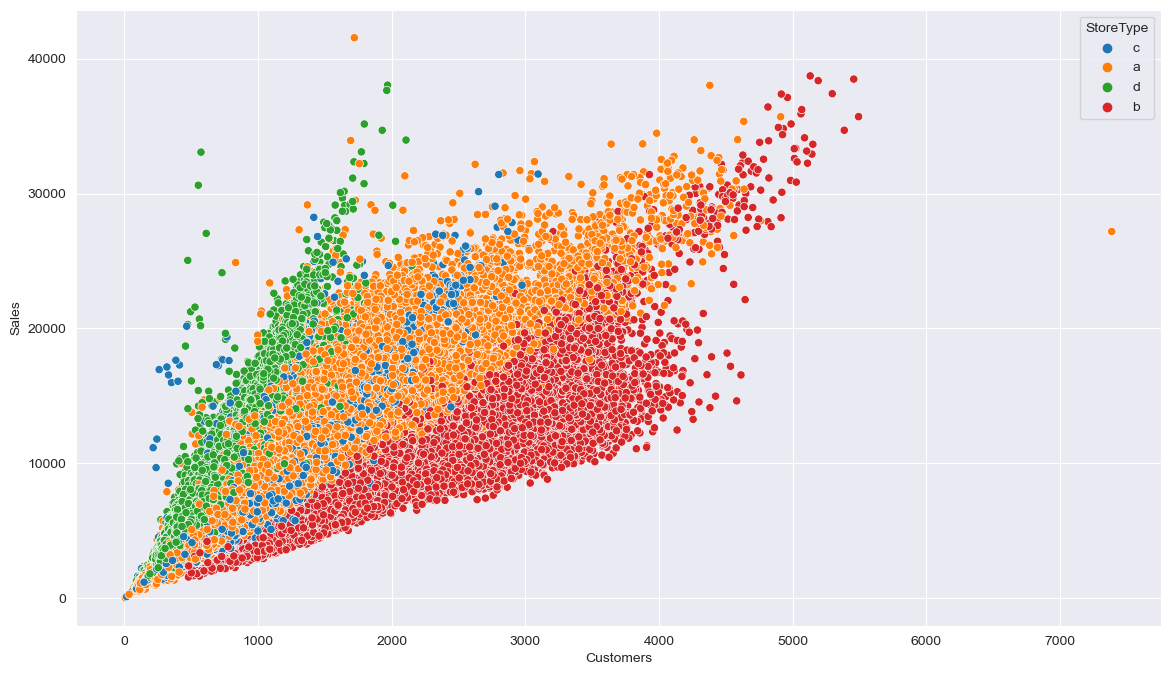

In [69]:
plt.figure(figsize = (14,8))
fig1 = sns.scatterplot(x = mergedData['Customers'], y = mergedData['Sales'],hue = mergedData['StoreType'])

#### Trend of Sales over time

In [70]:
fig5 = px.line(mergedData.groupby(['Date','StoreType']).mean()['Sales'].unstack())
fig5.show()

### Histogram of Sales vs StoreType 

C:\Users\mverd\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\mverd\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\mverd\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\mverd\anaconda3\lib\site-pac

<AxesSubplot:xlabel='Sales', ylabel='Density'>

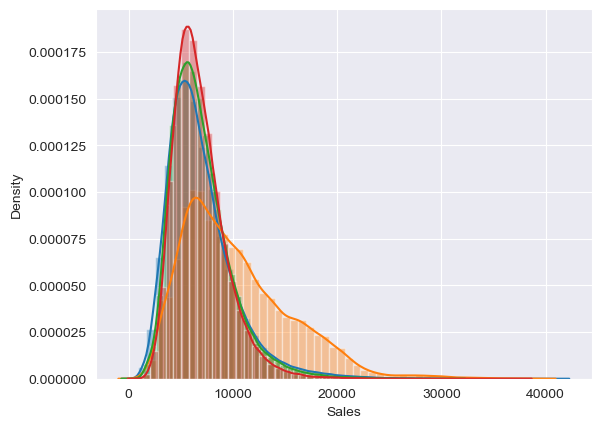

In [71]:
groupStoreType = list(mergedData['StoreType'].unique())
a = mergedData[mergedData['StoreType']=='a']['Sales']
b = mergedData[mergedData['StoreType']=='b']['Sales']
c = mergedData[mergedData['StoreType']=='c']['Sales']
d = mergedData[mergedData['StoreType']=='d']['Sales']

sns.distplot(mergedData[mergedData['StoreType']=='a']['Sales'])
sns.distplot(mergedData[mergedData['StoreType']=='b']['Sales'])
sns.distplot(mergedData[mergedData['StoreType']=='c']['Sales'])
sns.distplot(mergedData[mergedData['StoreType']=='d']['Sales'])

### Label Encoding

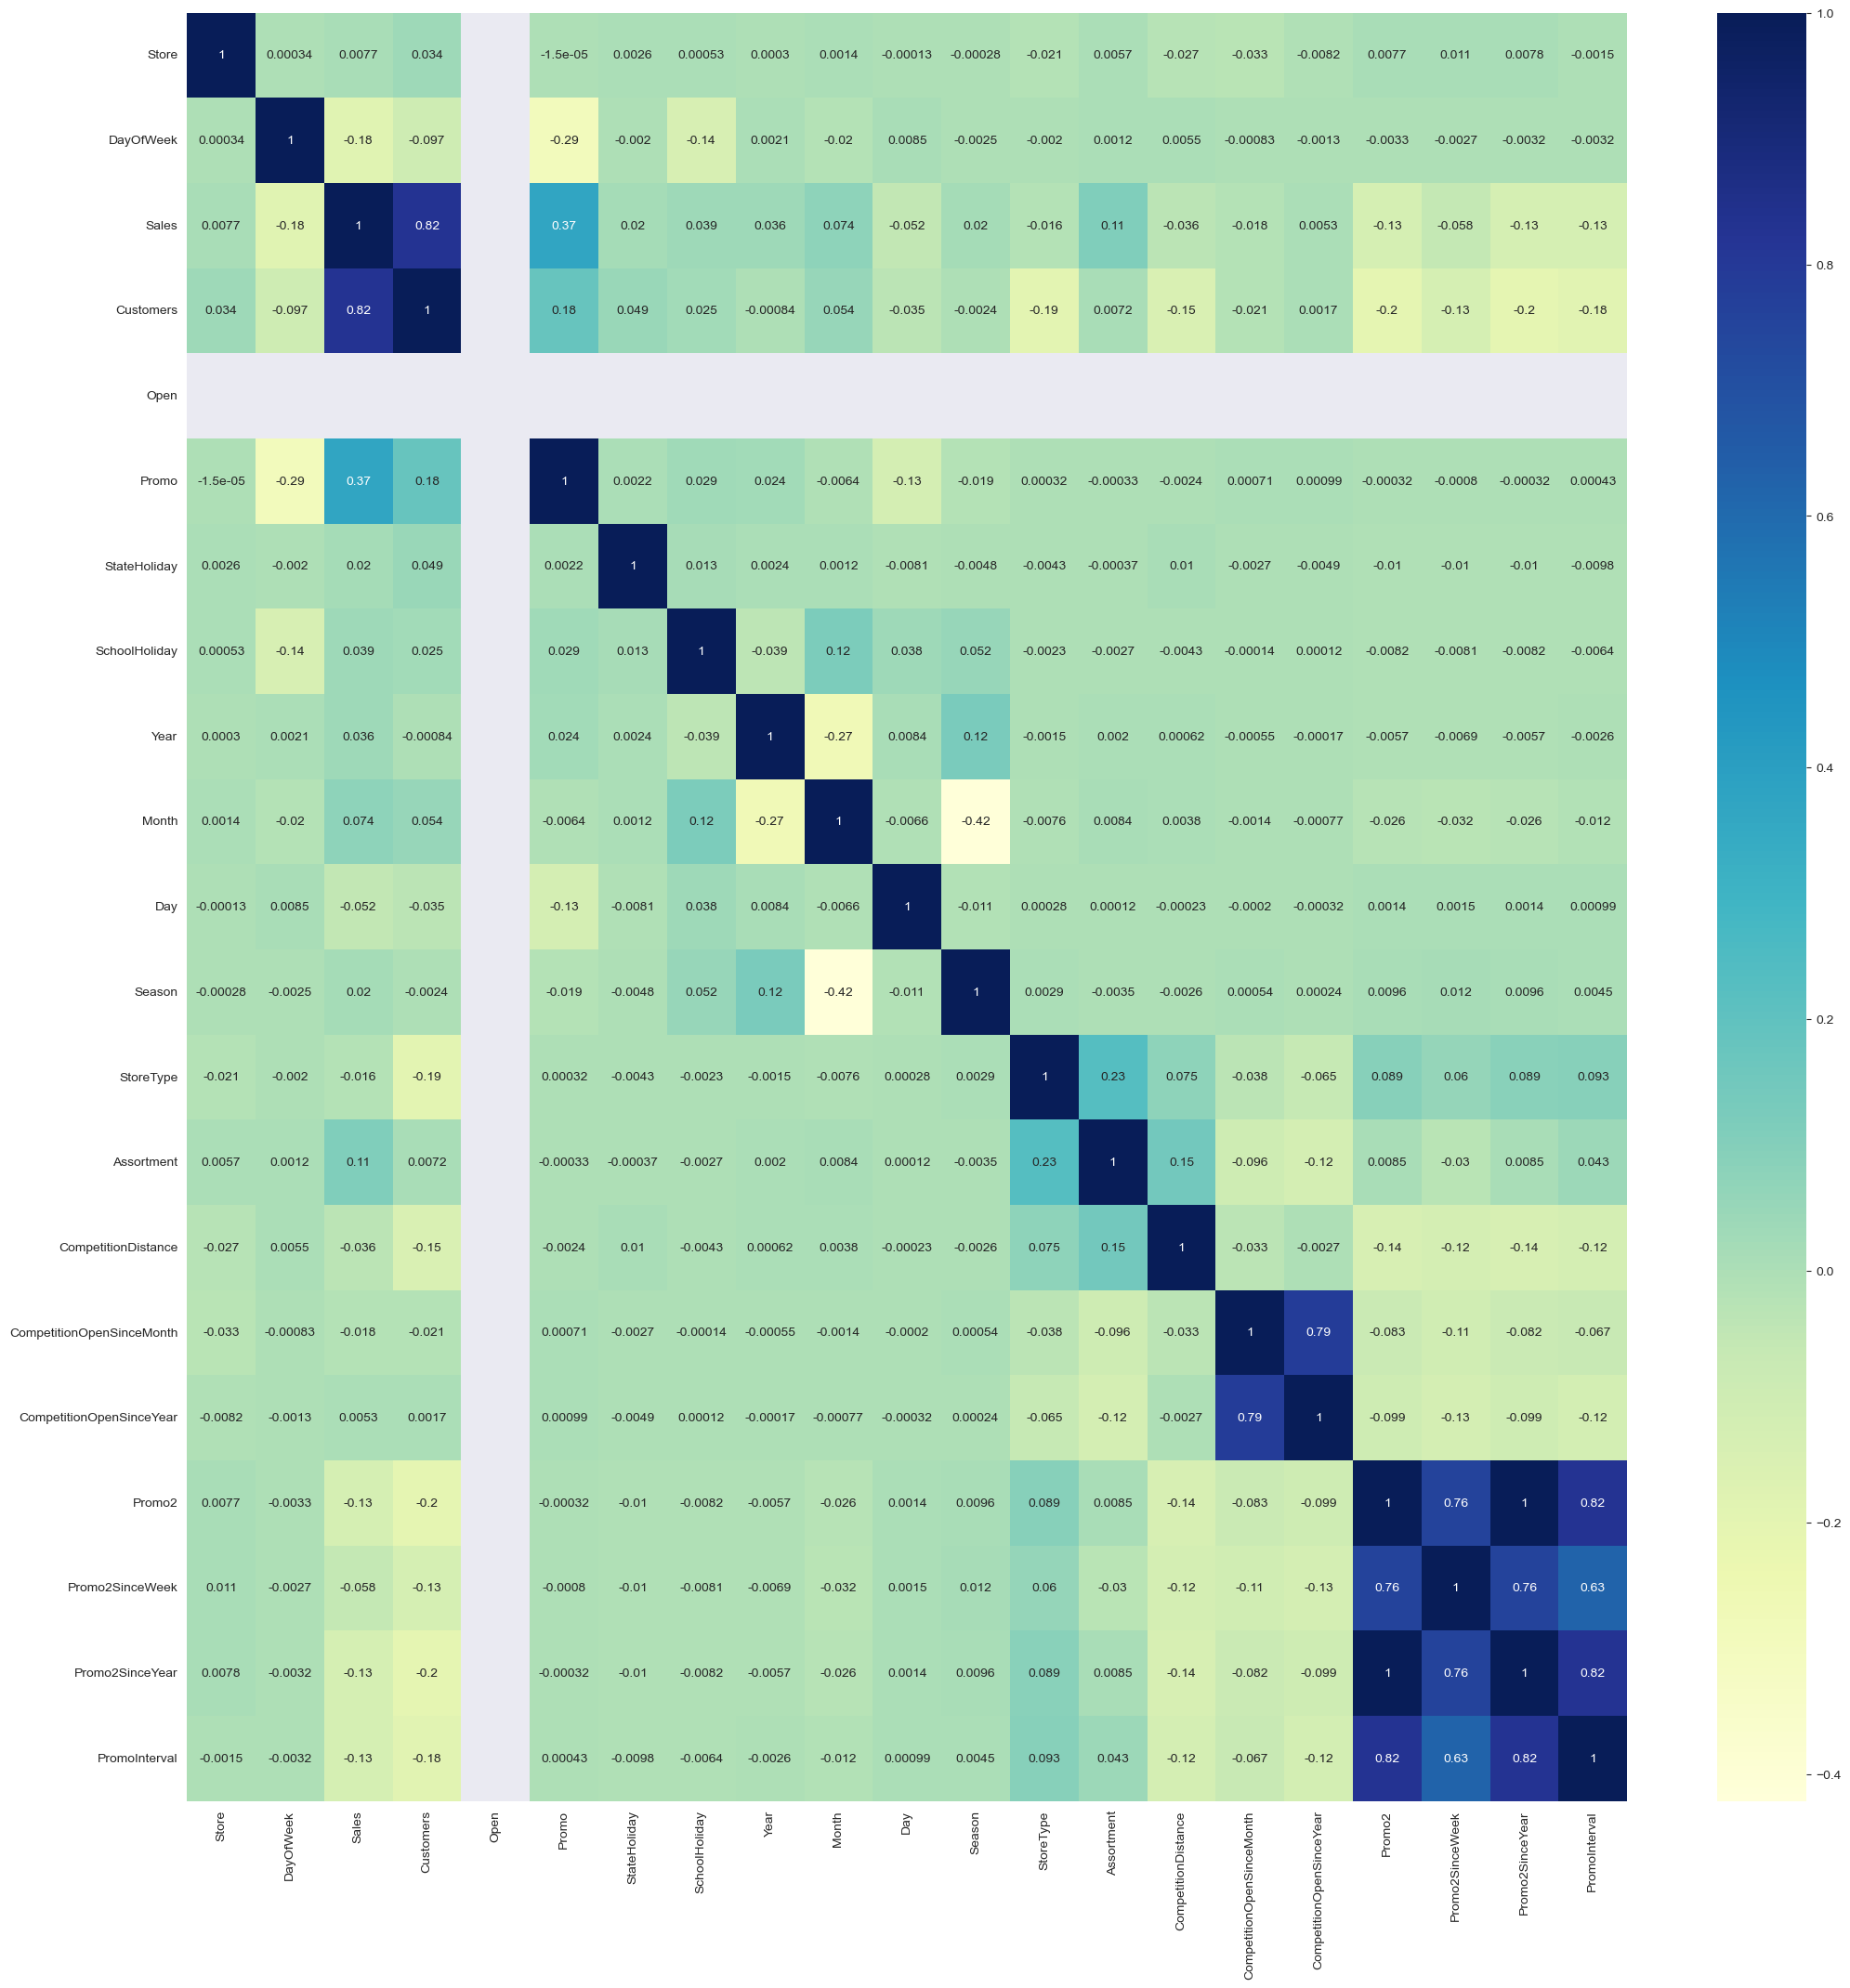

In [72]:
mergedData = LevelEncoding(mergedData, 'StoreType')
mergedData = LevelEncoding(mergedData,'Assortment')
mergedData = LevelEncoding(mergedData, 'Season')
StateHolidayMaps = {'0':0,'a':1,'b':1,'c':1}
mergedData['StateHoliday'].replace(StateHolidayMaps, inplace = True)
PromoIntervalMaps = {'Jan,Apr,Jul,Oct':1, 'Feb,May,Aug,Nov':2, 'Mar,Jun,Sept,Dec':3}
mergedData['PromoInterval'].replace(PromoIntervalMaps, inplace = True)

corrmatrix = mergedData.corr()
top_corr_features = corrmatrix.index
plt.figure(figsize = (25,25))
g=sns.heatmap(mergedData[top_corr_features].corr(),annot=True,cmap="YlGnBu")

#### Dropping columns that are highly correlated to Promo2

In [73]:
mergedData = mergedData.drop('Promo2SinceWeek', axis=1)
mergedData = mergedData.drop('Promo2SinceYear', axis=1)
mergedData = mergedData.drop('PromoInterval', axis=1)

#### Dropping one of the Competition Open Columns and Customers

In [74]:
mergedData = mergedData.drop('CompetitionOpenSinceMonth', axis=1)
mergedData = mergedData.drop('Customers', axis=1)

### Implementing Wrapper method For Feature Extraction

In [77]:
mergedData = mergedData.sample(frac=1).reset_index(drop=True)
mergedDataSample = mergedData.iloc[:100000,:]

ColumnNames = list(mergedDataSample.columns)
#PredictorColNames = ColumnNames['Sales']
Target = mergedDataSample['Sales']
ColumnNames.remove('Sales')
#PredictorColNames = ColumnNames
Predictor = mergedDataSample[ColumnNames]
#print(TargetColNames)
#print(ColumnNames)

PredictorSFS = Predictor
PredictorSFS = PredictorSFS.drop('Date', axis = 1)

sfs = SFS(knn(),
           k_features=8,
           forward=True,
           floating=True,
           scoring = 'accuracy',
           cv = 4,
         n_jobs=-1)

sfs.fit(PredictorSFS,Target);

SFS_outcome = pd.DataFrame(sfs.subsets_).transpose()
SFS_outcome

,feature_idx,cv_scores,avg_score,feature_names
1,"(2,)","[0.00016, 0.00036, 0.00024, 0.00024]",0.00025,"(Customers,)"
2,"(2, 13)","[0.00048, 0.00044, 0.00044, 0.00056]",0.00048,"(Customers, CompetitionDistance)"
3,"(0, 2, 13)","[0.0008, 0.00052, 0.00048, 0.00072]",0.00063,"(Store, Customers, CompetitionDistance)"
4,"(0, 2, 4, 13)","[0.00084, 0.00052, 0.00048, 0.00072]",0.00064,"(Store, Customers, Promo, CompetitionDistance)"
5,"(0, 2, 3, 4, 13)","[0.00084, 0.00052, 0.00048, 0.00072]",0.00064,"(Store, Customers, Open, Promo, CompetitionDis..."
6,"(0, 2, 3, 4, 5, 13)","[0.00084, 0.00052, 0.00048, 0.00072]",0.00064,"(Store, Customers, Open, Promo, StateHoliday, ..."
7,"(0, 2, 3, 4, 5, 6, 13)","[0.00084, 0.00052, 0.00048, 0.00072]",0.00064,"(Store, Customers, Open, Promo, StateHoliday, ..."
8,"(0, 2, 3, 4, 5, 6, 11, 13)","[0.00084, 0.00052, 0.00048, 0.00072]",0.00064,"(Store, Customers, Open, Promo, StateHoliday, ..."


# LSTM

In [79]:
numeric_cols = ['Store', 'DayOfWeek', 
               'Customers', 'Promo', 'StateHoliday',
              'SchoolHoliday', 'StoreType', 'CompetitionDistance', 
              'CompetitionOpenSinceYear','Year', 'Month','Day']

X_train, X_test, y_train, y_test = train_test_split(mergedData[numeric_cols], mergedData['Sales'], test_size=0.2, random_state=1000)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1000)

model = keras.models.Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (12, 1)))
model.add(keras.layers.Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dropout(0.2))

# Adding the output layer
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=["mean_absolute_error"])

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 2, validation_data = (X_test, y_test))

result = model.predict(X_val)
y_val.columns = ["Actual Sales","Predicted Sales"]

print(y_val.head(10))
print(result[:10])

Epoch 1/2
18998/18998 [==============================] - 359s 19ms/step - loss: 9924502.0000 - mean_absolute_error: 2213.5632 - val_loss: 2451146.7500 - val_mean_absolute_error: 1077.9479
Epoch 2/2
2111/2111 [==============================] - 14s 6ms/step
580662     3685
304422     8360
526033    10813
596937     8317
183873     8990
9455      16020
17012      4803
229326     1901
838520     5315
247439     4879
Name: Sales, dtype: int64
[[ 3256.9338]
 [ 8186.8413]
 [11502.585 ]
 [ 8634.94  ]
 [ 8150.6846]
 [14547.112 ]
 [ 3494.8384]
 [ 3048.4282]
 [ 6914.025 ]
 [ 4984.3125]]


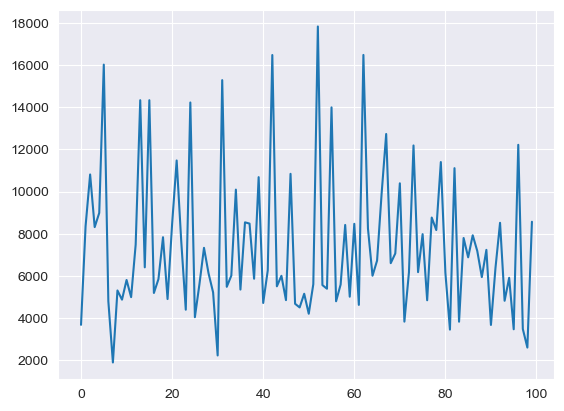

In [81]:
fig = plt.figure(1)
plt.plot(range(0,100), y_val.head(100)) # plot first line
#plt.plot(range(0,100), result[:100]) # plot second line
plt.show()